In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib






---




# Image classification on CIFAR-10

**This project can be used to present in showcase day as extra credits.**

### Preliminaries information:
In this problem we will explore different deep learning architectures for image classification on the CIFAR-10
dataset. If you are not comfortable with PyTorch from the previous lecture and discussion materials, use the tutorials at http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html and make sure you
are familiar with tensors, two-dimensional convolutions (`nn.Conv2d`) and fully-connected layers (`nn.Linear`),
ReLU non-linearities (`F.relu`), pooling (`nn.MaxPool2d`), and tensor reshaping (`view`).

For this problem, it is highly recommended that you copy and modify the existing network code produced in
the tutorial *Training a classifier*. You should not be coding this network from scratch!



- Each network $f$ maps an image $x^{\rm in} \in \mb{R}^{32 \times 32 \times 3}$ (3 channels for RGB) to an output $f(x^{\rm in}) = x^{\rm out} \in \mb{R}^{10}$. The class label is predicted as $\arg\max_{i=0,1,\dots,9} x_{i}^{\rm out}$.

- The network is trained via multiclass cross-entropy loss (log of softmax function).  Specifically, for an input image and label pair $(x^{\rm in} , c)$ where $c\in \{0,\dots, 9\}$. If the network’s
output layer is $x^{\rm out} \in \mb{R}^{10}$, the loss $-\log\left(\frac{\exp(x_c^{\rm out})}{\sum_{c'} \exp(x_{c'}^{\rm out})}\right)$.

- For computational efficiency reasons, this particular network considers mini-batches of images per training
step meaning the network actually maps $B=4$ images per feed-forward so that $\tilde{x}^{\rm in}\in\mb{R}^{B\times 32 \times 32 \times 3}$ and $\tilde{x}^{\rm out}\in\mb{R}^{B\times 10}$.  This is ignored in the network descriptions below but it is something to be aware of.

- Create a validation dataset by appropriately partitioning the train dataset. **Hint**: look at the documentation for `torch.utils.data.random\_split`. Make sure to tune hyperparameters like network architecture and step size on the validation dataset. Do **NOT** validate your hyperparameters on the test dataset.

- Modify the training code such that at the end of each epoch (one pass over the training data) it computes and prints the training and test classification accuracy.

- The cross-entropy loss for a neural network is, in general, non-convex. This means that the optimization
method may converge to different local minima based on different hyperparameters of the optimization
procedure (e.g., stepsize). Usually one can find a good setting for these hyperparameters by just observing
the relative progress of training over the first epoch or two (how fast is it decreasing) but you are warned
that early progress is not necessarily indicative of the final convergence value (you may converge quickly to a poor local minimum whereas a different step size could have poor early performance but converge to
a better final value).

- While one would usually train a network for hundreds of epochs to reach convergence and maximize accuracy, this can be prohibitively time-consuming, so feel free to train for just a a dozen or so epochs.


**Your Task:**
For all of the following,
- Apply a **hyperparameter tuning method** (manually by
hand, grid search, random search, etc.) using the
validation set

- Report the hyperparameter configurations you evaluated and the best set of hyperparameters
from this set.  

- Plot the training and validation classification accuracy as a function of iteration. Produce
a separate line or plot for each hyperparameter configuration evaluated (please try to use multiple lines in a single plot to keep the number of figures minimal).

- Finally, evaluate your best set of
hyperparameters on the test data and report the accuracy.



The number of hyperparameters to tune, combined with the slow training times, will hopefully give
you a taste of how difficult it is to construct networks with good generalization performance. It should be emphasized that the
networks we constructed are **tiny**.
State-of-the-art networks can have dozens of layers, each with their own hyperparameters to tune. Additional
hyperparameters you are welcome to play with if you are so inclined, include: changing the activation
function, replace max-pool with average-pool, adding more convolutional or fully connected layers, and
experimenting with batch normalization or dropout.


Here are the network architectures you will construct and compare.
Before you jump into tuning, it is better to write  separate train and evaluation functions.

---







In [ ]:
sns.set()
torch.manual_seed(592)
np.random.seed(592)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# it may takes while to download the data, please try this code several times.
def prepare_dataset(batch_size=64, train_val_split_ratio=0.9):

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    cifar10_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    train_size = int(len(cifar10_set) * train_val_split_ratio)
    val_size   = len(cifar10_set) - train_size

    cifar10_trainset, cifar10_valset = torch.utils.data.random_split(cifar10_set, [train_size, val_size])
    cifar10_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(cifar10_valset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(cifar10_testset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader


In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs, batch_size):
    """Trains a model for n epochs using given optimizer, and then records
    validation and training accuracies, validation and training losses.
    """
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = total_train_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        model.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = total_val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{epochs} => '
              f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}% | '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Move the return statement outside of the outer loop
    return train_losses, val_losses, train_accuracies, val_accuracies


In [ ]:
def evaluation(model, test_loader, criterion):
    """ Calculate and print test accuracy and test losses.
    """
    model.eval()
    total_test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test

    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    return avg_test_loss, test_accuracy

##  Fully-connected output, no hidden layers (logistic regression)
We begin with the simplest network
possible that has no hidden layers and simply linearly maps the input layer to the output layer. That is,
conceptually it could be written as
\begin{align*}
    x^{\rm out} &= W \text{vec}(x^{\rm in}) +b
\end{align*}
where $x^{\rm out} \in \mb{R}^{10}$, $x^{\rm in} \in \mb{R}^{32 \times 32 \times 3}$, $W \in \mb{R}^{10 \times 3072}$, $b \in \mb{R}^{10}$ since $3072 = 32 \cdot 32 \cdot 3$. For a tensor $x \in \mb{R}^{a \times b \times c}$, we let $\text{vec}(x) \in \mb{R}^{a b c}$ be the reshaped form of the tensor into a vector (in an arbitrary but consistent pattern).   There is no required benchmark testing accuracy for this part.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.utils.data

class LogisticRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = self.fc(x)
        return x

# Set the device for training
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define constants
input_size = 32 * 32 * 3  # Flattened size of CIFAR-10 images
output_size = 10  # Number of classes in CIFAR-10
epochs = 15
batch_size = 64

# Create an instance of the LogisticRegression model
logistic_model = LogisticRegression(input_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(logistic_model.parameters(), lr=0.001)

In [ ]:
train_loader, val_loader, test_loader = prepare_dataset(batch_size=batch_size, train_val_split_ratio=0.9)

# Train the logistic regression model
train_losses, val_losses, train_accuracies, val_accuracies = train(logistic_model, train_loader, val_loader, criterion, optimizer, epochs, batch_size)

# Evaluate the model
evaluation(logistic_model, test_loader, criterion)


100%|██████████| 170498071/170498071 [00:03<00:00, 51832764.65it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1/15 => Training Loss: 2.0110, Training Accuracy: 29.24% | Validation Loss: 1.9112, Validation Accuracy: 34.68%
Epoch 2/15 => Training Loss: 1.8797, Training Accuracy: 35.86% | Validation Loss: 1.8494, Validation Accuracy: 38.20%
Epoch 3/15 => Training Loss: 1.8390, Training Accuracy: 37.44% | Validation Loss: 1.8254, Validation Accuracy: 38.46%
Epoch 4/15 => Training Loss: 1.8162, Training Accuracy: 38.32% | Validation Loss: 1.8080, Validation Accuracy: 39.04%
Epoch 5/15 => Training Loss: 1.8004, Training Accuracy: 38.78% | Validation Loss: 1.7999, Validation Accuracy: 39.88%
Epoch 6/15 => Training Loss: 1.7899, Training Accuracy: 39.35% | Validation Loss: 1.7913, Validation Accuracy: 40.24%
Epoch 7/15 => Training Loss: 1.7786, Training Accuracy: 39.59% | Validation Loss: 1.7784, Validation Accuracy: 40.38%
Epoch 8/15 => Training Loss: 1.7707, Training Accuracy: 40.02% | Validation Loss: 1.7

(1.7486758756030136, 40.28)

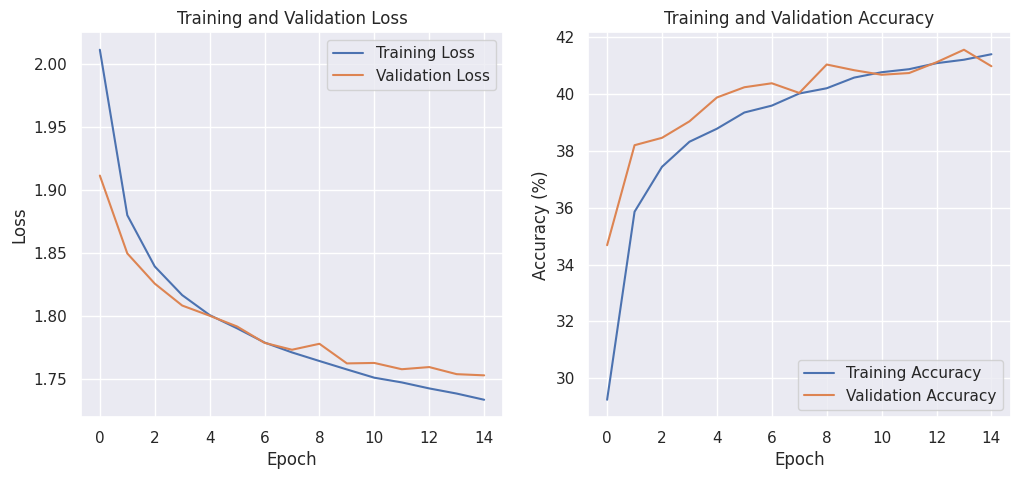

In [ ]:
# Plotting the results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Discuss your findings:



---


## Fully-connected output, 1 fully-connected hidden layer

We will have one hidden layer denoted as $x^{\rm hidden} \in \mb{R}^{M}$ where $M$ will be a hyperparameter you choose ($M$ could be in the hundreds). The non-linearity applied to the hidden layer will be the **relu** ($\mathrm{relu}(x) = \max\{0,x\}$, elementwise). This network can be written as

\begin{align*}
    x^{\rm out} &= W_2 \mathrm{relu}(W_1 \text{vec}(x^{\rm in}) +b_1) + b_2
\end{align*}

where $W_1 \in \mb{R}^{M \times 3072}$, $b_1 \in \mb{R}^M$, $W_2 \in \mb{R}^{10 \times M}$, $b_2 \in \mb{R}^{10}$.  Tune the different hyperparameters and train for
a sufficient number of epochs to achieve a testing accuracy of at least 50%. Provide the hyperparameter
configuration used to achieve this performance.



In [ ]:
#  your code starts here
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.utils.data

# Define the neural network architecture
class FullyConnected(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FullyConnected, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define constants
input_size = 32 * 32 * 3  # Flattened size of CIFAR-10 images
output_size = 10  # Number of classes in CIFAR-10
epochs = 15
batch_size = 64
hidden_size = 512  # Start with a hidden layer size of 512

In [ ]:
# Create the model, loss function, and optimizer
model = FullyConnected(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the logistic regression model
train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, val_loader, criterion, optimizer, epochs, batch_size)

# Evaluate the model on the test set
test_loss, test_accuracy = evaluation(model, test_loader, criterion)

Epoch 1/15 => Training Loss: 1.8930, Training Accuracy: 33.94% | Validation Loss: 1.7327, Validation Accuracy: 40.02%
Epoch 2/15 => Training Loss: 1.6722, Training Accuracy: 41.87% | Validation Loss: 1.6265, Validation Accuracy: 44.06%
Epoch 3/15 => Training Loss: 1.5866, Training Accuracy: 44.84% | Validation Loss: 1.5781, Validation Accuracy: 45.70%
Epoch 4/15 => Training Loss: 1.5293, Training Accuracy: 47.04% | Validation Loss: 1.5439, Validation Accuracy: 46.84%
Epoch 5/15 => Training Loss: 1.4848, Training Accuracy: 48.62% | Validation Loss: 1.5106, Validation Accuracy: 47.98%
Epoch 6/15 => Training Loss: 1.4459, Training Accuracy: 50.15% | Validation Loss: 1.4894, Validation Accuracy: 49.06%
Epoch 7/15 => Training Loss: 1.4092, Training Accuracy: 51.56% | Validation Loss: 1.4596, Validation Accuracy: 49.98%
Epoch 8/15 => Training Loss: 1.3750, Training Accuracy: 52.81% | Validation Loss: 1.4453, Validation Accuracy: 50.30%
Epoch 9/15 => Training Loss: 1.3440, Training Accuracy: 

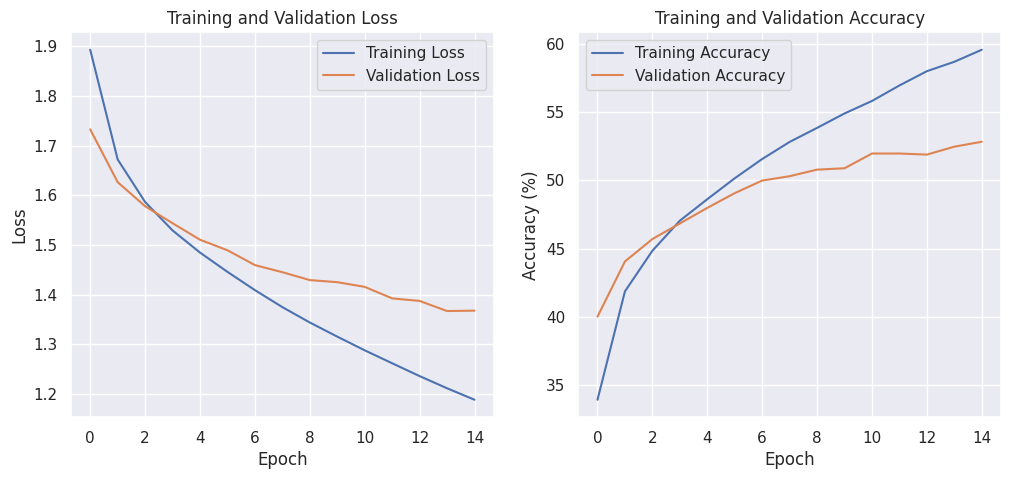

In [ ]:
# Plotting the results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()



---


## Convolutional layer with max-pool and fully-connected output

For a convolutional layer $W_1$ with filters of size $k \times k \times 3$, and $M$ filters (reasonable choices are $M=100$, $k=5$), we have that $\mathrm{Conv2d}(x^{\rm in}, W_1) \in \mb{R}^{(33-k) \times (33-k) \times M}$.

- Each convolution will have its own offset applied to each of the output pixels of the convolution; we denote this as $\mathrm{Conv2d}(x^{\rm in}, W) + b_1$ where $b_1$ is parameterized in $\mb{R}^M$. Apply a **relu** activation to the result of the convolutional layer.

-  Next, use a max-pool of size $N \times N$ (a reasonable choice is $N=14$ to pool to $2 \times 2$ with $k=5$) we have that $\textrm{MaxPool}( \mathrm{relu}( \mathrm{Conv2d}(x^{\rm in}, W_1)+b_1)) \in \mb{R}^{\lfloor\frac{33-k}{N}\rfloor \times \lfloor\frac{33-k}{N}\rfloor \times M}$.

- We will then apply a fully-connected layer to the output to get a final network given as
\begin{align*}
          x^{\rm output} = W_2 \text{vec}(\textrm{MaxPool}( \mathrm{relu}( \mathrm{Conv2d}(x^{\rm input}, W_1)+b_1))) + b_2
\end{align*}
where $W_2 \in \mb{R}^{10 \times M (\lfloor\frac{33-k}{N}\rfloor)^2}$, $b_2 \in \mb{R}^{10}$.


The parameters $M, k, N$ (in addition to the step size and momentum) are all hyperparameters, but you
can choose a reasonable value. Tune the different hyperparameters (number of convolutional filters, filter
sizes, dimensionality of the fully-connected layers, stepsize, etc.) and train for a sufficient number of
epochs to achieve a validation accuracy of **at least 70%**. Provide the hyperparameter configuration used
to achieve this performance. Make sure to save this model so that you can do the next part.


In [ ]:
#  Q3 your code starts here
class CNN(nn.Module):
    def __init__(self, M, k, N):
        super(CNN, self).__init__()
        self.conv_layer = nn.Conv2d(3, M, kernel_size=k, padding=k//2)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=N, stride=N)
        self.flatten = nn.Flatten()
        self.fc_layer = nn.Linear(M * (32//N) * (32//N), 10)

    def forward(self, x):
        x = x.to(self.conv_layer.weight.device)
        x = self.conv_layer(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc_layer(x)
        return x
M = 1024
k = 5
N = 14
learning_rate = 0.005
epochs = 30


In [ ]:
model = CNN(M, k, N)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

train_loader, val_loader, test_loader = prepare_dataset()

train_losses, val_losses, train_accuracies, val_accuracies= train(model, train_loader, val_loader, criterion, optimizer, epochs, batch_size=64)

evaluation(model, test_loader, criterion)

torch.save(model.state_dict(), 'cnn_model.pth')

100%|██████████| 170498071/170498071 [00:03<00:00, 45868641.38it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1/30 => Training Loss: 1.6857, Training Accuracy: 39.78% | Validation Loss: 1.4880, Validation Accuracy: 43.54%
Epoch 2/30 => Training Loss: 1.3789, Training Accuracy: 51.72% | Validation Loss: 1.3094, Validation Accuracy: 54.54%
Epoch 3/30 => Training Loss: 1.2736, Training Accuracy: 55.66% | Validation Loss: 1.2661, Validation Accuracy: 55.50%
Epoch 4/30 => Training Loss: 1.1945, Training Accuracy: 59.12% | Validation Loss: 1.1623, Validation Accuracy: 60.34%
Epoch 5/30 => Training Loss: 1.1343, Training Accuracy: 61.06% | Validation Loss: 1.2192, Validation Accuracy: 58.28%
Epoch 6/30 => Training Loss: 1.0932, Training Accuracy: 62.78% | Validation Loss: 1.1123, Validation Accuracy: 61.40%
Epoch 7/30 => Training Loss: 1.0550, Training Accuracy: 64.10% | Validation Loss: 1.0485, Validation Accuracy: 64.36%
Epoch 8/30 => Training Loss: 1.0153, Training Accuracy: 65.48% | Validation Loss: 1.0

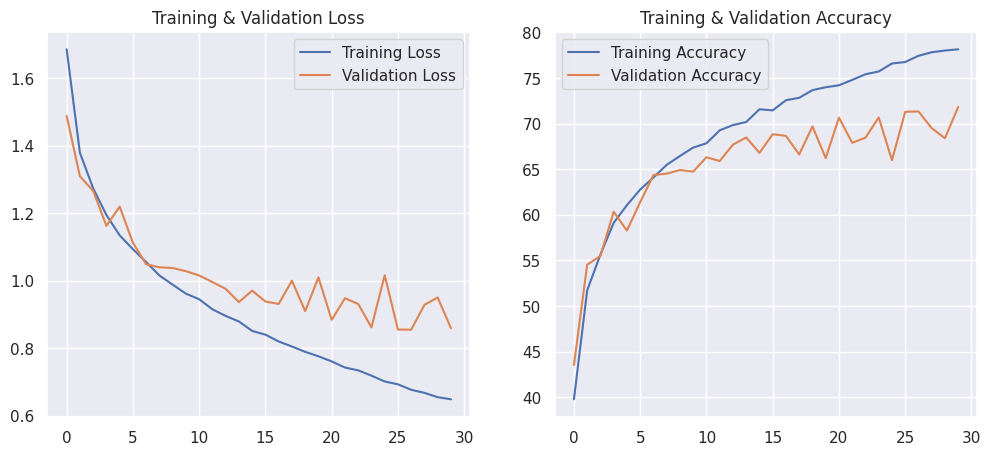

In [ ]:
import matplotlib.pyplot as plt

# Assuming `train_losses`, `val_losses`, `train_accuracies`, `val_accuracies` are recorded during training
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()


# Discuss your findings:



---


## More tuning

Return to the original network you were left with at the end of the tutorial Training
a classifier. (Note that this is not the network above.) Tune the different hyperparameters
(number of convolutional filters, filter sizes, dimensionality of the fully-connected layers, stepsize, etc.) and
train for a sufficient number of iterations to achieve a *train accuracy* of **at least 87%**. You may not modify
the core structure of the model (i.e., adding additional layers). Provide the hyperparameter configuration
used to achieve this performance. Make sure to save this model so that you can do the next part (see
the Training a classifier tutorial for details on how to do this).

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Instantiate the model
model = Net().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
# Loss and optimizer with adjusted learning rate and weight decay
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4)  # Adjust learning rate and add weight decay

train_loader, val_loader, test_loader = prepare_dataset()

# Train the logistic regression model
train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, val_loader, criterion, optimizer, epochs = 30, batch_size=64)

# Evaluate the model on the test set
test_loss, test_accuracy = evaluation(model, test_loader, criterion)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30 => Training Loss: 2.0511, Training Accuracy: 24.66% | Validation Loss: 1.6994, Validation Accuracy: 36.30%
Epoch 2/30 => Training Loss: 1.5806, Training Accuracy: 42.13% | Validation Loss: 1.4777, Validation Accuracy: 46.58%
Epoch 3/30 => Training Loss: 1.4101, Training Accuracy: 48.59% | Validation Loss: 1.3915, Validation Accuracy: 48.44%
Epoch 4/30 => Training Loss: 1.2916, Training Accuracy: 53.52% | Validation Loss: 1.2383, Validation Accuracy: 55.56%
Epoch 5/30 => Training Loss: 1.2030, Training Accuracy: 57.22% | Validation Loss: 1.2101, Validation Accuracy: 57.30%
Epoch 6/30 => Training Loss: 1.1295, Training Accuracy: 60.05% | Validation Loss: 1.1938, Validation Accuracy: 58.46%
Epoch 7/30 => Training Loss: 1.0642, Training Accuracy: 62.46% | Validation Loss: 1.2436, Validation Accuracy: 56.38%
Epoch 8/30 => Training Loss: 1.0214, Training Accuracy: 63.87% | Validation Loss: 1.1320, Validati

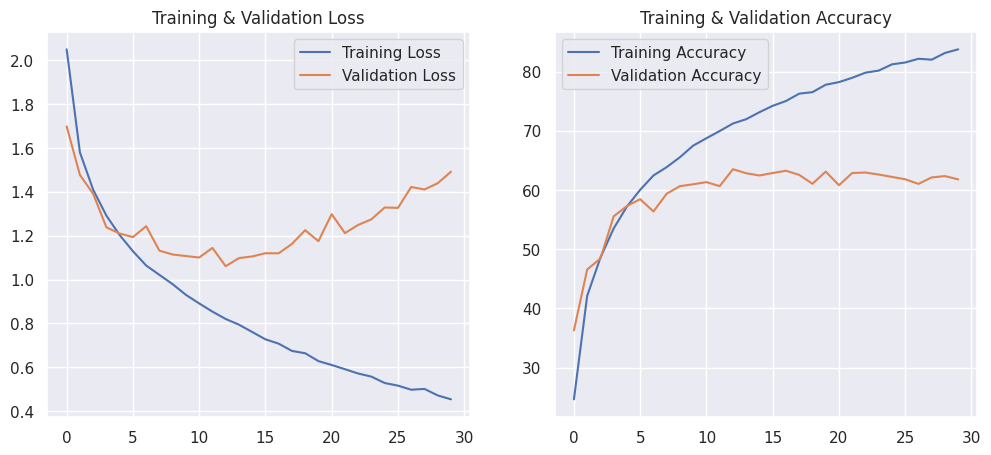

In [ ]:
import matplotlib.pyplot as plt

# Assuming `train_losses`, `val_losses`, `train_accuracies`, `val_accuracies` are recorded during training
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()


In [ ]:
# Define the original network architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)  # Increase the number of filters
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)  # Increase the number of filters
        self.fc1 = nn.Linear(64 * 5 * 5, 512)  # Adjust the dimensionality
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def train_original(model, train_loader, val_loader, criterion, optimizer, epochs, batch_size, scheduler=None):
    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        if scheduler:
            scheduler.step()

        # Record training accuracy and loss
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        print(f'Epoch {epoch + 1}/{epochs}, '
              f'Training Loss: {train_loss:.4f}, '
              f'Training Accuracy: {100 * train_accuracy:.2f}%')

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

            # Record validation accuracy and loss
            val_accuracy = correct_val / total_val
            val_accuracies.append(val_accuracy)
            val_losses.append(val_loss / len(val_loader))

            print(f'Validation Loss: {val_losses[-1]:.4f}, '
                  f'Validation Accuracy: {100 * val_accuracy:.2f}%')

        # Early stopping: If validation accuracy plateaus, break the loop
        if epoch > 1 and val_accuracies[-1] == val_accuracies[-2]:
            print("Early stopping. Validation accuracy plateaued.")
            break

    return train_accuracies, train_losses, val_accuracies, val_losses


In [ ]:
# Data transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

val_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False)

# Instantiate the original model
original_net = Net()
original_net.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(original_net.parameters(), lr=0.01, momentum=0.9)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

# Train the model
train_accuracies, train_losses, val_accuracies, val_losses = train_original(original_net, train_loader, val_loader, criterion, optimizer, epochs=50, batch_size=64, scheduler=scheduler)

# Save the model
torch.save(original_net.state_dict(), 'tuned_original_model.pth')

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/17, Training Loss: 1.6952, Training Accuracy: 37.91%
Validation Loss: 1.3694, Validation Accuracy: 51.16%
Epoch 2/17, Training Loss: 1.2404, Training Accuracy: 55.57%
Validation Loss: 1.1498, Validation Accuracy: 58.70%
Epoch 3/17, Training Loss: 1.0498, Training Accuracy: 62.80%
Validation Loss: 0.9912, Validation Accuracy: 65.60%
Epoch 4/17, Training Loss: 0.9255, Training Accuracy: 67.58%
Validation Loss: 0.8627, Validation Accuracy: 70.07%
Epoch 5/17, Training Loss: 0.8366, Training Accuracy: 70.51%
Validation Loss: 0.8215, Validation Accuracy: 71.77%
Epoch 6/17, Training Loss: 0.7584, Training Accuracy: 73.56%
Validation Loss: 0.8125, Validation Accuracy: 72.32%
Epoch 7/17, Training Loss: 0.7046, Training Accuracy: 75.16%
Validation Loss: 0.7614, Validation Accuracy: 73.44%
Epoch 8/17, Training Loss: 0.6484, Training Accuracy: 77.25%
Validation Loss: 0.7372, Validation Accuracy: 74.72%
Epoch 9/17, 

In [ ]:
# Evaluate on the test data
test_loss, test_accuracy = evaluation(original_net, val_loader, criterion)

Test Loss: 0.7410, Test Accuracy: 78.51%


NameError: name 'train_losses' is not defined

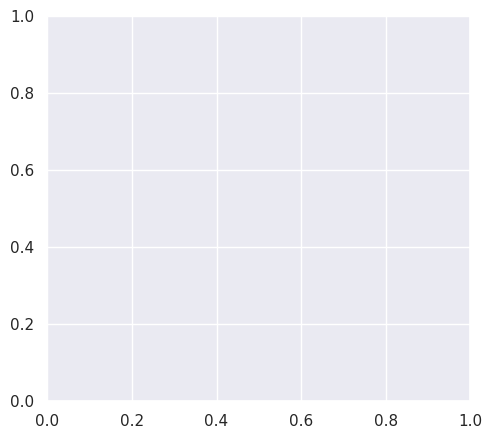

In [ ]:
import matplotlib.pyplot as plt

# Assuming `train_losses`, `val_losses`, `train_accuracies`, `val_accuracies` are recorded during training
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()

# Discuss your findings:



---

## Transfer Learning:  Use AlexNet as a fixed feature extractor
So far we have trained very small neural networks from scratch. As mentioned in the previous problem,
modern neural networks are much larger and more difficult to train and validate. In practice, it is rare to train
such large networks from scratch. This is because it is difficult to obtain both the massive datasets and the
computational resources required to train such networks.

Instead of training a network from scratch, in this problem, we will use a network that has already been trained
on a very large dataset (ImageNet) and adjust it for the task at hand. This process of adapting weights in a
model trained for another task is known as **transfer learning**.

Begin with the pretrained **AlexNet** model from `torchvision.models` for the following tasks below. AlexNet
achieved an early breakthrough performance on ImageNet and was instrumental in sparking the deep
learning revolution in 2012.

Do not modify any module within AlexNet that is not the final classifier layer.

- The output of AlexNet comes from the 6-th layer of the classifier. Specifically, `model.classifer[6] =
nn.Linear(4096, 1000)`. To use AlexNet with CIFAR-10, we will reinitialize (replace) this layer with
`nn.Linear(4096, 10)`. This re-initializes the weights, and changes the output shape to reflect the desired
number of target classes in CIFAR-10.

- We only adjust the weights of this new layer (keeping the weights of all other layers
fixed). When using AlexNet as a fixed feature extractor, make sure to freeze all of the parameters in the network
before adding your new linear layer:
 ```
model = torchvision.models.alexnet(pretrained=True)
for param in model.parameters():
param.requires_grad = False
model.classifier[6] = nn.Linear(4096, 10)
```








In [ ]:
import torchvision.models as models
import torch.nn as nn

# Load pretrained AlexNet
alexnet = models.alexnet(pretrained=True)

# Freeze parameters
for param in alexnet.parameters():
    param.requires_grad = False

# Modify the classifier for CIFAR-10
alexnet.classifier[6] = nn.Linear(4096, 10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:04<00:00, 51.5MB/s]


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transform pipeline
transform = transforms.Compose([
    transforms.Resize(224),  # Resize images to fit AlexNet's expectations
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# CIFAR-10 datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 170498071/170498071 [00:03<00:00, 47705670.70it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.classifier[6].parameters(), lr=0.001)
# Assuming 'train' is a function you've defined earlier for training
train_losses, val_losses, train_accuracies, val_accuracies = train(
    alexnet, train_loader, test_loader, criterion, optimizer, epochs=5, batch_size=64
)
# Assuming 'evaluation' is a function you've defined earlier for evaluation
test_loss, test_accuracy = evaluation(alexnet, test_loader, criterion)

Epoch 1/5 => Training Loss: 0.7203, Training Accuracy: 74.97% | Validation Loss: 0.5526, Validation Accuracy: 80.43%
Epoch 2/5 => Training Loss: 0.6235, Training Accuracy: 78.47% | Validation Loss: 0.5293, Validation Accuracy: 81.59%
Epoch 3/5 => Training Loss: 0.6070, Training Accuracy: 78.99% | Validation Loss: 0.5204, Validation Accuracy: 82.20%
Epoch 4/5 => Training Loss: 0.6027, Training Accuracy: 79.39% | Validation Loss: 0.5205, Validation Accuracy: 81.68%
Epoch 5/5 => Training Loss: 0.5975, Training Accuracy: 79.46% | Validation Loss: 0.5340, Validation Accuracy: 82.10%
Test Loss: 0.5340, Test Accuracy: 82.10%


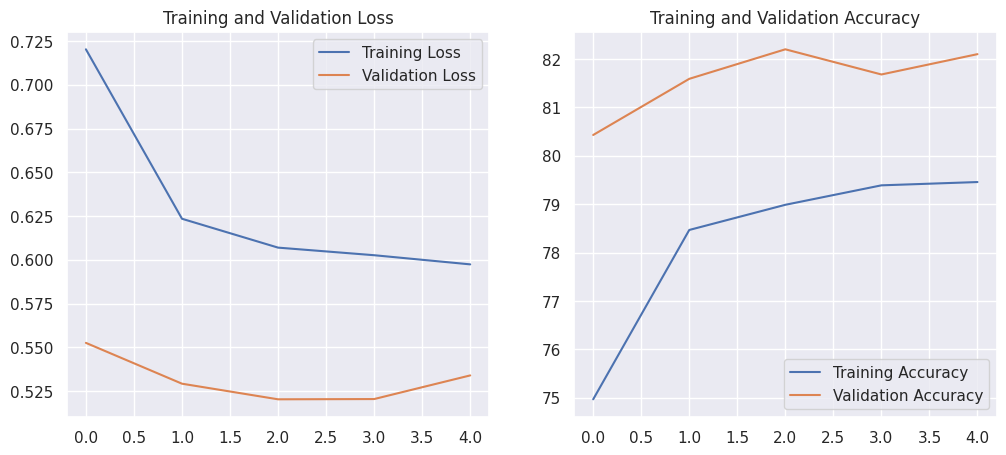

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


In [ ]:
torch.save(alexnet.state_dict(), 'alexnet_cifar10.pth')

# Discuss your findings:



---


## Transfer Learning: Use AlexNet as initialization (10pt)
The second approach to transfer learning is to fine-tune the weights of the pretrained network, in addition to training the new classification layer. In this approach, all network weights
are updated at every training iteration; we simply use the existing AlexNet weights as the “initialization”
for our network (except for the weights in the new classification layer, which will be initialized using
whichever method is specified in the constructor) prior to training on CIFAR-10.

**Note**: Fine-tune AlexNet on
CPU takes an insame amount of time, so we recommend you to use Google Colab, which has free GPU
access. To enable GPU for the notebook: Navigate to Edit→Notebook Settings. select GPU from the
Hardware Accelerator drop-down. For information about training on GPU, check the tutorial.

In [ ]:
import torchvision.models as models
import torch.nn as nn

# Load the pretrained AlexNet model
alexnet = models.alexnet(pretrained=True)

# Modify the final classifier layer
alexnet.classifier[6] = nn.Linear(4096, 10)  # CIFAR-10 has 10 classes


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize(224),  # AlexNet expects 224x224 inputs
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
val_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_losses, val_losses, train_accuracies, val_accuracies = train(alexnet, train_loader, val_loader, criterion, optimizer, epochs=5, batch_size=64)

# Evaluate on the test data
test_loss, test_accuracy = evaluation(alexnet, test_loader, criterion)

Epoch 1/5 => Training Loss: 0.6008, Training Accuracy: 79.08% | Validation Loss: 0.4324, Validation Accuracy: 85.10%


# Discuss your findings:



---


## Adversarial Attacks

Modern deep neural networks are brittle and susceptible to small
perturbations to their inputs. This gives rise to adversarial examples, which are nearly indistinguishable
to the human eye but somehow “fool” neural networks into making drastically wrong predictions.

One algorithm to generate such examples is the untargeted fast gradient sign method (FGSM) attack,
which can be described as follows:
Let $x$ be an input image with label $y$, $F$ be a neural network, and $\epsilon$ be a small value (intuitively, an attack rate).

\begin{align}
&\hat{y} = F(x) \\
&L= \text{CrossEntropy}(\hat{y},y) \\
&x' = x+\epsilon \cdot \text{sign}(\nabla_x L)
\end{align}

where $\text{sign}(t) = \frac{t}{|t|}$.  We then use $x'$ as an input to the network. Note that the calculation for $x'$
loosely resembles gradient descent. Intuitively, we are slightly adjusting the input image so that the model is less
likely to predict its true class.

For this part, use your classifier from the third network to do the following steps. As always, please provide all code
and plots.

- Select four images from the train set that have been correctly classified. Visualize them and provide
their labels.

- Implement the untargeted FGSM algorithm. Run one iteration on these images and visualize them:
they should look like the originals.

- Provide the predicted labels for your attacked images. You should have at least one image that is
incorrectly classified. Remark: **FGSM** is a simple attack, but it’s not always effective. In order to
generate successful adversarial examples, you may need to try different values of $\epsilon$ or even different
images, depending on where your classifier excels.

- Explain the significance of the existence of such adversarial examples.



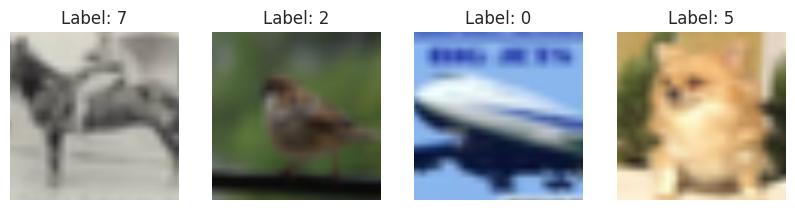

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Assuming 'model' is already defined and trained, and 'train_loader' is set up
model.eval()
correct_images = []
correct_labels = []

# Get some correctly classified images
with torch.no_grad():
    for images, labels in train_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels)
        for i in range(len(images)):
            if len(correct_images) < 4 and correct[i]:
                correct_images.append(images[i])
                correct_labels.append(labels[i])
        if len(correct_images) == 4:
            break

# Plotting correctly classified images
fig, axes = plt.subplots(1, 4, figsize=(10, 2.5))
for idx, img in enumerate(correct_images):
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    axes[idx].imshow(img)
    axes[idx].set_title(f'Label: {correct_labels[idx].item()}')
    axes[idx].axis('off')
plt.show()


In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)  # keep the image in the range [0,1]
    return perturbed_image


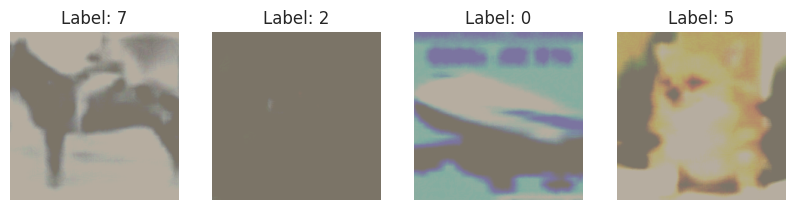

In [ ]:
epsilon = 0.01  # Epsilon: small enough to be imperceptible, yet large enough to cause misclassification

# Attacking the correctly classified images
adv_images = []
for img, label in zip(correct_images, correct_labels):
    img.requires_grad = True
    output = model(img.unsqueeze(0))
    loss = F.cross_entropy(output, label.unsqueeze(0))
    model.zero_grad()
    loss.backward()
    data_grad = img.grad.data
    perturbed_data = fgsm_attack(img, epsilon, data_grad)
    adv_images.append(perturbed_data)

# Visualize the perturbed images
fig, axes = plt.subplots(1, 4, figsize=(10, 2.5))
for idx, img in enumerate(adv_images):
    img = img.detach().numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    axes[idx].imshow(img)
    axes[idx].set_title(f'Label: {correct_labels[idx].item()}')
    axes[idx].axis('off')
plt.show()


In [ ]:
for img, label in zip(correct_images, correct_labels):
        img.requires_grad = True
        output = model(img.unsqueeze(0))
        loss = F.cross_entropy(output, label.unsqueeze(0))
        model.zero_grad()
        loss.backward()
        data_grad = img.grad.data
        perturbed_data = fgsm_attack(img, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        print(f'Original label: {label.item()}, Predicted label after attack: {predicted.item()}')


Original label: 7, Predicted label after attack: 2
Original label: 2, Predicted label after attack: 2
Original label: 0, Predicted label after attack: 0
Original label: 5, Predicted label after attack: 5


####Significance of Adversarial Examples
Adversarial examples are significant for several reasons:

- Security Implications: They expose vulnerabilities in models that could be exploited maliciously in real-world applications, such as autonomous vehicles or facial recognition systems.
- Robustness: Studying adversarial attacks helps in understanding and improving the robustness of neural networks against such examples.
- Research Tool: They provide a valuable tool for researchers to probe and understand the decision boundaries and behavior of neural networks.